# Построение модели прогнозирования оттока клиентов

Заказчик - оператор связи - хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель**: обучить модель прогнозирования оттока клиентов на основе предоставленных данных с показателем AUC-ROC не менее 0.85. 

**Задачи**:
- Провести исследовательский анализ данных. 
- Обучить несколько моделей, выбрать лучшую.
- Протестировать модель на тестовой выборке, проанализировать результат. 
- Написать отчет для заказчика.

## План 

1. EDA
- Преобразование типов данных
- Просмотр распределения и аномалий, дублей, пропусков
- Выделение целевого признака
- Сбор данных в одну таблицу
- Работа с пропусками
2. Моделирование 
- Отбор необходимые для обучения признаки и создание новых
- Деление данных на train и test в соотношении 3 к 1 
- Кодирование признаков
- Обучение 2-3 моделей, выброр лучшей. 
- Оценка модели на тестовой выборке, анализ важности признаков. 
3. Отчет 
- Описание ключевых шагов работы 
- Анализ соответствия фактической работы запланированной
- Оценка проблем и путей их решения
- Построение итогового списка признаков с расшифровкой
- Описание предобработки признаков
- Описание предобработки данных в целом
- Построение таблицы лучших моделей и их метрик на кросс-валидации 
- Описание лучшей модели, ее название, гиперпараметры и метрика. 
- Описание итоговой метрики лучшей модели не тестовой выборке(ROC-AUC и accuracy)
- Построение матрицы ошибок для лучшей модели

## Импорты

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import phik
import catboost
import numpy as np


from phik.report import plot_correlation_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostClassifier 
from catboost import Pool

## Исследовательский анализ данных

### Импортирование данных

In [2]:
contract_data = pd.read_csv('contract_new.csv')

In [3]:
personal_data = pd.read_csv('personal_new.csv')

In [4]:
internet_data = pd.read_csv('internet_new.csv')

In [5]:
phone_data = pd.read_csv('phone_new.csv')

### Анализ данных по контрактам

In [7]:
contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [8]:
temp = contract_data.copy() 
print(temp.info())
for col_l in temp.columns:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
          ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%') 
print('-'* 25) 
print('кол-во дубликатов в датафрейме', temp.duplicated().sum(),
      ', процент дубликатов', round(temp.duplicated().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
-------------------------
customerID ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customerID : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
BeginDate ['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2

Интерес вызывает столбец TotalCharges в котором неожиданно оказались пропуски, при этом они отображаются как ' ', поэтому технически пропусками не считаются, но весь столбец получил тип object. Посмотрим на них.

In [9]:
contract_data.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как можно заметить, все эти клиенты только заключили договор на момент выгрузки и никаких денег еще не заплатили, соответственно заполняем TotalCharges нулями.

In [10]:
contract_data.loc[contract_data['TotalCharges'] == ' ', 'TotalCharges'] = '0' 

Выделим ключевой признак, чтобы можно было спокойно работать со столбцом EndDate, записи 'No' мешают преобразовать его в тип с датой, которую потом хотелось бы использовать для подсчета длительности обслуживания.

In [11]:
contract_data['label'] = contract_data['EndDate'].apply(lambda x: 0 if x == 'No' else 1) 
print(contract_data['label'].unique()) 
print(contract_data['label'].mean())

[0 1]
0.15632542950447254


Получили вполне ожидаемый баланс классов, теперь заменим записи "No" на заглушку. Осознанно ставим здесь тип None, чтобы посмотреть распределение уходящих клиентов.

In [12]:
contract_data.loc[contract_data['EndDate'] == 'No', 'EndDate'] = None

Теперь меняем тип данных в некоторых столбцах.

In [13]:
contract_data = contract_data.astype({'TotalCharges':'float64'}) 
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d') 
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format='%Y-%m-%d')

In [14]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


С типами все, посмотрим распределения.

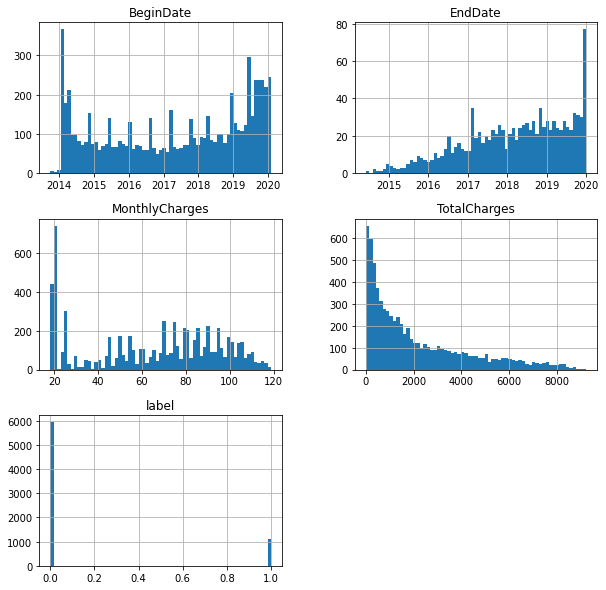

In [15]:
contract_data.hist(figsize=(10, 10), bins=65);

В целом все логично, графики MonthlyCharges и TotalCharges отражают то, что большая часть клиентов находится на недорогих тарифах. Компания постепенно растет, поэтому увеличивается и отток клиентов - это можно увидеть на графиках BeginDate и EndDate. Единственное, есть небольшой пик в 2020 года на графике оттока, но масштаб цифр здесь небольшой и это вполне возможно.

Уберем None, заполним их датой выгрузки, чтобы потом можно было посчитать продолжительность обслуживания на момент выгрузки.

In [16]:
contract_data['EndDate'] = contract_data['EndDate'].fillna('2020-02-01') 
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format='%Y-%m-%d')

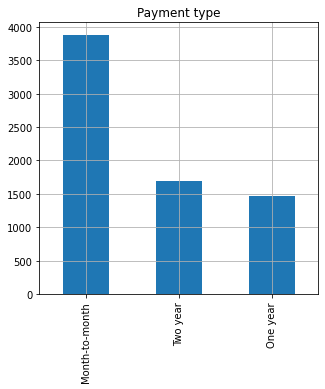

In [17]:
contract_data.groupby('Type')['Type'].count().sort_values(ascending=False).plot(kind='bar', 
                                                                                grid=True, 
                                                                                figsize=(5, 5), 
                                                                                title='Payment type',
                                                                                xlabel=''
                                                                                );

Ожидаемо большая часть клиентов, порядка 54 процентов, платит помесячно.

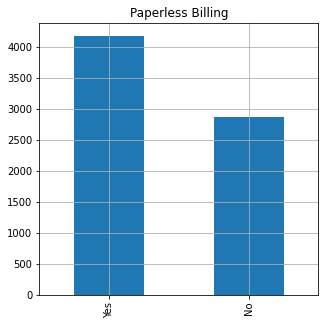

In [18]:
contract_data.groupby('PaperlessBilling')['PaperlessBilling'].count().sort_values(ascending=False).plot(kind='bar', 
                                                                                                        grid=True, 
                                                                                                        figsize=(5, 5), 
                                                                                                        title='Paperless Billing',
                                                                                                        xlabel=''
                                                                                                        );

Как не странно, довольно большой процент клиентов - примерно 40% пользуется бумажными платежными документами.

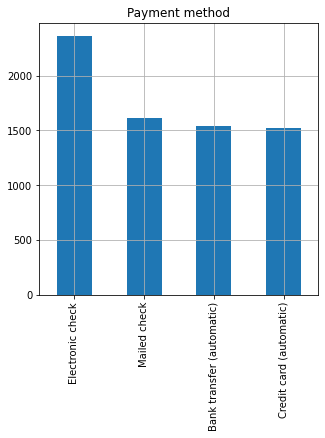

In [19]:
contract_data.groupby('PaymentMethod')['PaymentMethod'].count().sort_values(ascending=False).plot(kind='bar', 
                                                                                                  grid=True, 
                                                                                                  figsize=(5, 5), 
                                                                                                  title='Payment method',
                                                                                                  xlabel=''
                                                                                                  );

Значительное количество клиентов, чуть меньше четверти все еще получает чеки по почте, чуть меньше половины клиентов пользуется автоплатежем.

### Анализ персональных данных

In [20]:
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [21]:
temp = personal_data.copy() 
print(temp.info())
for col_l in temp.columns:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
          ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%') 
print('-'* 25) 
print('кол-во дубликатов в датафрейме', temp.duplicated().sum(),
      ', процент дубликатов', round(temp.duplicated().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
-------------------------
customerID ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customerID : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
gender ['Female' 'Male']
gender : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
SeniorCitizen [0 1]
SeniorCitizen : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Partner ['No' 'Yes']
Partner : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Dependents ['No' 'Yes']
Dependents : кол-во NaN 0 , процент NaN 

Здесь, вроде бы, никих подозрительных значений нет. Посмотрим распределения.

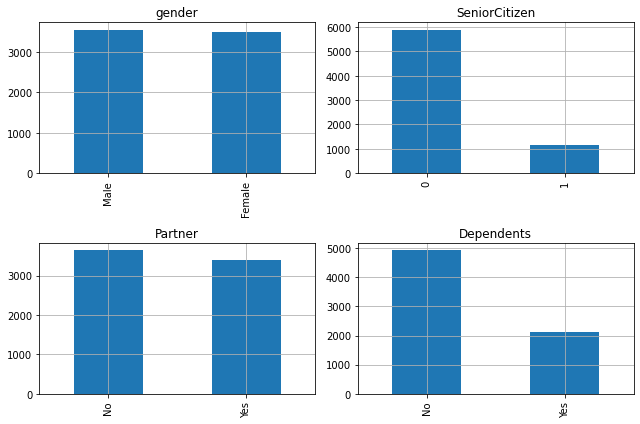

In [22]:
columns = temp.columns.drop('customerID') 
n = columns.shape[0] 
rows = n // 2 + (n % 2 > 0) 
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(3*3, 3*rows)) 
for i, column in enumerate(columns): 
    r = i // 2 
    c = i % 2 
    ax = axes[r][c] 
    temp.groupby(column)[column].count().sort_values(ascending=False).plot(kind='bar', ax=ax, grid=True, title=column, xlabel='') 
plt.tight_layout() 
plt.show() 

Таким образом:
- пол пользователей распределен примерно поровну
- среди клиентов примерно 14% пенсионеров
- чуть меньше половины пользователей состоят в браке 
- у примерно 26% пользователей есть иждивенцы

### Интернет-услуги

In [23]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [24]:
temp = internet_data.copy() 
print(temp.info())
for col_l in temp.columns:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
          ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%') 
print('-'* 25) 
print('кол-во дубликатов в датафрейме', temp.duplicated().sum(),
      ', процент дубликатов', round(temp.duplicated().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
-------------------------
customerID ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
customerID : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
InternetService ['DSL' 'Fiber optic']
InternetService : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
OnlineSecurity ['No' 'Yes']
OnlineSecurity : кол-во NaN 0 , процент NaN 0.0 %


Аналогично предыдущей таблице начего подозрительного вроде бы и нет, не все клиенты компании пользуются ее услугами интернета, поэтому записей стало меньше.

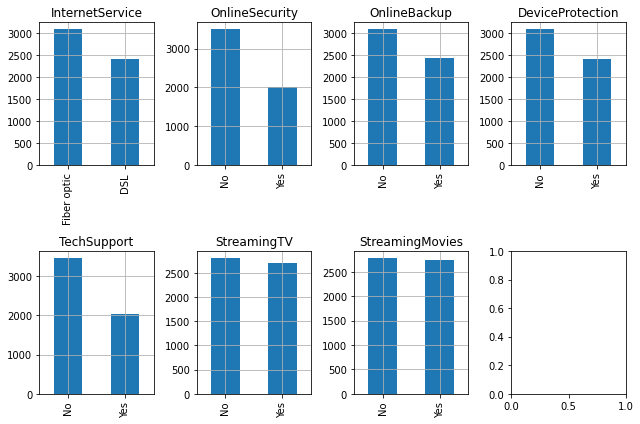

In [25]:
columns = temp.columns.drop('customerID') 
n = columns.shape[0] 
rows = n // 4 + (n % 4 > 0) 
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(3*3, 3*rows)) 
for i, column in enumerate(columns): 
    r = i // 4 
    c = i % 4 
    ax = axes[r][c] 
    temp.groupby(column)[column].count().sort_values(ascending=False).plot(kind='bar', ax=ax, grid=True, title=column, xlabel='') 
plt.tight_layout() 
plt.show() 

Таким образом:
- порядка 54% клиентов используют оптоволоконное соединение 
- 36% пользуются блокировщиком небезопасных сайтов
- 44% используют антивирус 
- 36% имеют выделенную линию поддержки
- примерно 50% смотрят стриминговое TV и столько же имеют доступ к каталогу фильмов

### Услуги сотовой связи

In [26]:
temp = phone_data.copy() 
print(temp.info())
for col_l in temp.columns:
    print('-'* 25)
    print(col_l, temp[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
          ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%') 
print('-'* 25) 
print('кол-во дубликатов в датафрейме', temp.duplicated().sum(),
      ', процент дубликатов', round(temp.duplicated().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
-------------------------
customerID ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-RRAMN' '9992-UJOEL'
 '9993-LHIEB']
customerID : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
MultipleLines ['No' 'Yes']
MultipleLines : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
кол-во дубликатов в датафрейме 0 , процент дубликатов 0.0 %


In [27]:
phone_data = phone_data.astype({'customerID':'str'})

Пользователей телефонной связи несколько больше, чем интернета. Явных проблем в данных не видно.

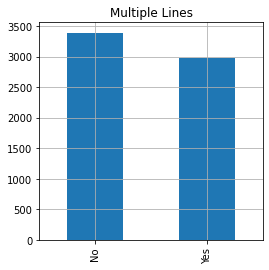

In [28]:
phone_data.groupby('MultipleLines')['MultipleLines'].count().sort_values(ascending=False).plot(kind='bar', 
                                                                                               grid=True, 
                                                                                               figsize=(4, 4), 
                                                                                               title='Multiple Lines',
                                                                                               xlabel=''
                                                                                               );

Примерно 45% клиентов используют несколько линий связи.

### Объединение таблиц

Объединять будем постепенно, чтобы не запутуться в природе пропусков.

In [29]:
full_data = contract_data.copy()

In [30]:
full_data = full_data.merge(personal_data, on='customerID')

На этом этапе пропусков быть не должно, в personal_data присутствуют данные о всех клиентах.

In [31]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(7)
memory usage: 770.3+ KB


Отлично, идем дальше

In [32]:
full_data = full_data.merge(internet_data, on='customerID', how='left')

In [33]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

Данные пропуски появились поскольку не все клиенты компании пользуются ее услугами интернета, соответсвенно, заполним пропуски фразой "Dont use internet service"

In [34]:
full_data = full_data.fillna('Dont use internet service')

In [35]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Отлично

In [36]:
full_data = full_data.merge(phone_data, on='customerID', how='left')

In [37]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Ситуация аналогичная, только в этот раз не все пользуюся сотовой связью от компании.

In [38]:
full_data = full_data.fillna('Dont use phone service')

In [39]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   label             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [40]:
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,Dont use phone service
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,Dont use phone service
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Все получилось, теперь еще раз посмотрим на распределения категориальных признаков.

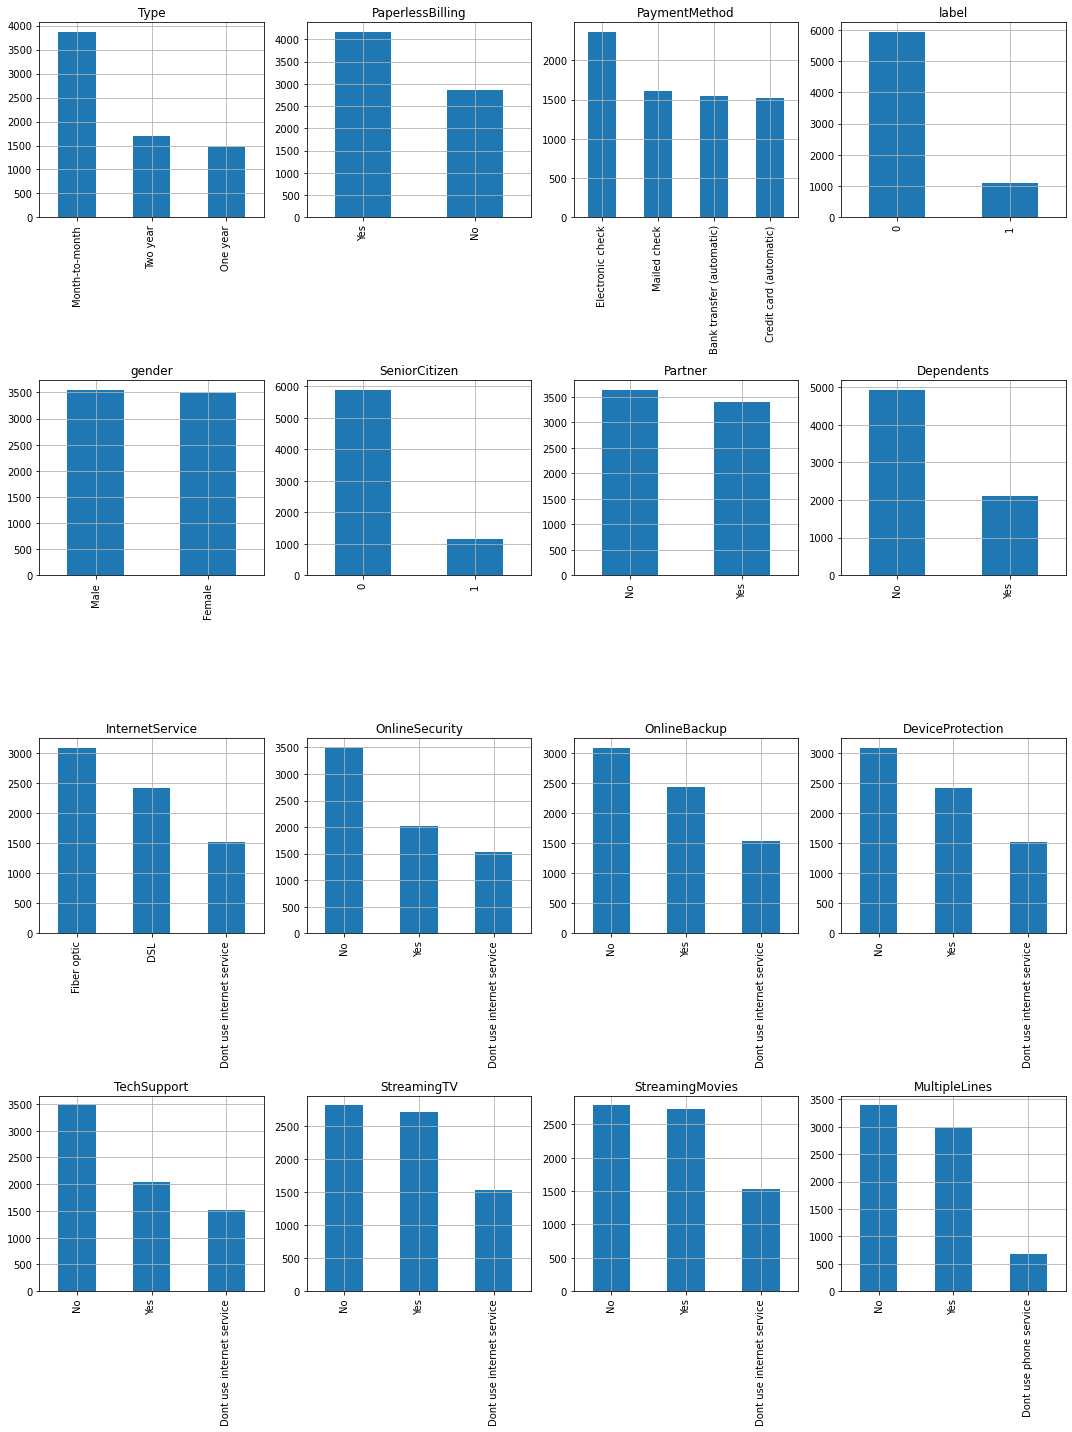

In [41]:
temp = full_data.copy()
columns = temp.columns.drop(['customerID', 'MonthlyCharges', 'TotalCharges', 'BeginDate', 'EndDate']) 
n = columns.shape[0] 
rows = n // 4 + (n % 4 > 0) 
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(3*5, 5*rows)) 
for i, column in enumerate(columns): 
    r = i // 4 
    c = i % 4 
    ax = axes[r][c] 
    temp.groupby(column)[column].count().sort_values(ascending=False).plot(kind='bar', ax=ax, grid=True, title=column, xlabel='') 
plt.tight_layout() 
plt.show()

После объединения распределения несколько изменились, примерно 21% клиентов компании не пользуются ее услугами интернета, что отражается на всех признаках, связанных с ним. Кроме того, примерно 9% клиентов не пользуются услугами телефонной связи, что можно увидеть на графике MultipleLines.

### Выводы по исследовательскому анализу

- Имеем датасет на 7043 наблюдения.
- Все таблицы просмотрены, исправлены некоторые аномалии.
- Не все клиенты используют одновременно услуги интернета и сотовой связи компании. 
- Данные объединены в одну таблицу, учтен предыдущий пункт при заполнении пропусков.
- Выделен целевой признак, целевой класс в датасете составляет 15% наблюдений, что в рамках нормы.

## Моделирование

### Работа с признаками

Первым напрашивается длительность обслуживания

In [42]:
full_data['Service_duration'] =  full_data['EndDate'] - full_data['BeginDate'] 
full_data['Service_duration'] = full_data['Service_duration'].dt.days

In [43]:
full_data['Service_duration'].head()

0      31
1    1036
2     123
3    1371
4     153
Name: Service_duration, dtype: int64

Хорошо. Далее удалим столбцы customerID, BeginDate, EndDate. Первый нам в принципе ничего интересного не дает, второй и третий учтены в столбце с длительностью

In [44]:
full_data = full_data.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

Перейдем к анализу взаимосвязи признаков, учтем, что не все они являются количественными, то есть обычные коэффициент кореляции Пирсона будет работать некорректно, воспользуемся библиотекой phik.

In [45]:
data_types = {'Type': 'categorical',
              'PaperlessBilling':'categorical',
              'Partner':'categorical', 
              'Dependents':'categorical', 
              'InternetService':'categorical', 
              'OnlineSecurity':'categorical', 
              'OnlineBackup':'categorical', 
              'DeviceProtection':'categorical', 
              'TechSupport':'categorical', 
              'StreamingTV':'categorical', 
              'StreamingMovies':'categorical', 
              'DeviceProtection':'categorical', 
              'MultipleLines':'categorical', 
              'Service_duration':'interval',
              'MonthlyCharges':'interval',
              'TotalCharges':'interval',
              } 
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in full_data.columns] 
interval_cols 

['Service_duration', 'MonthlyCharges', 'TotalCharges']

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Service_duration
Type,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.000000,0.086231,0.179736,0.147680,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.000000,0.242133,0.013218,0.172593,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.000000,0.292725,0.243008,0.224903,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.008175,0.304985,0.203545,0.184366,0.919002,0.812632,0.818851,0.827272,0.816660,0.864677,0.863616,0.709983,0.387727
TotalCharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.000000,0.135650,0.381958,0.084247,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787,0.848337
label,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.008581,0.086159,0.226688,0.046871,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101,0.374569
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,1.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.000000,1.000000,0.016992,0.324576,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.000000,0.016992,1.000000,0.652122,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.084247,0.046871,0.000000,0.324576,0.652122,1.000000,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198,0.198729


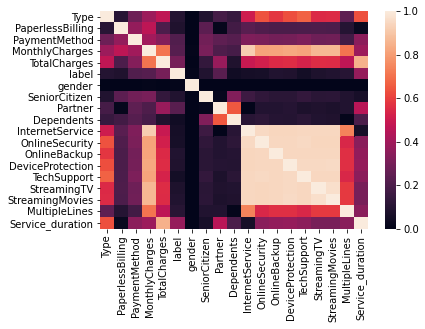

In [46]:
phik_overview = full_data.phik_matrix(interval_cols=interval_cols) 
sns.heatmap(phik_overview) 
phik_overview

Заметно, что признаков с сильной связью с целевым признаком у нас в принципе нет, при это есть целый квадрат мильтиколлинеарности. Отфильтруем признаки по от уровня связи в 0,1 и посмотрим подробнее, фильтровать будем "по вертикали".

In [47]:
sns.set(rc={'figure.figsize':(10,10)})
phik_overview = phik_overview.query('label > 0.1')

Технически, не очень корректная фильтрация, но тут ничего лишнего удалено не было.

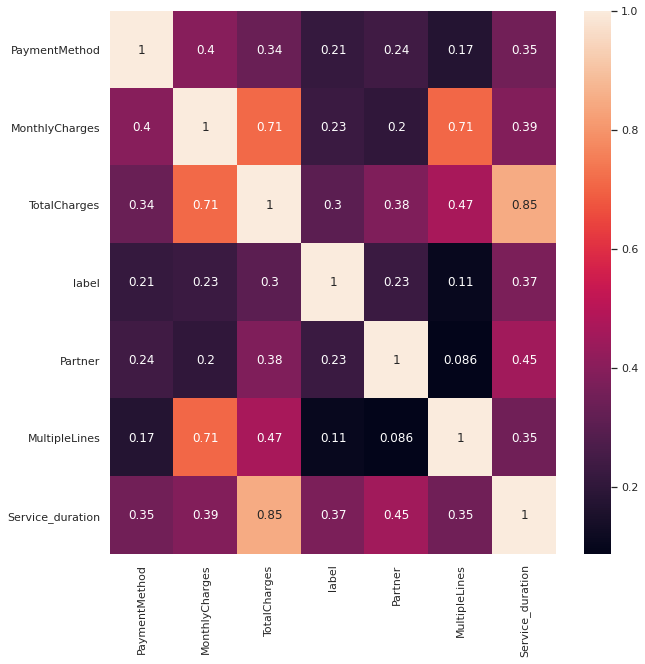

In [48]:
columns = phik_overview.index
sns.heatmap(phik_overview[columns], annot=True);

Уже неплохо, единственное, нужно убрать MultipleLines (коррелирует с MonthlyCharges) и убрать или Service_duration, или TotalChargers, уберу TotalChargers. В обоих случаях основываемся на силе связи с целевым признаком.

In [49]:
features_columns = phik_overview.query('label > 0.1 and label != 1') \
                                .drop(['MultipleLines', 'TotalCharges']) \
                                .index 
features_columns

Index(['PaymentMethod', 'MonthlyCharges', 'Partner', 'Service_duration'], dtype='object')

### Деление на выборки

In [50]:
features_train, features_test, target_train, target_test = train_test_split(
                                                                            full_data[features_columns], full_data['label'], 
                                                                            test_size=0.25, random_state=170723
                                                                            ) 

### Кодирование признаков

Буду использовать две модели, CatBoost и случайный лес. Для CatBoost создадам параметр cat_features и pool, последний сильно ускоряет обучение. Почти наверняка бустинг будет лучше, но интересно посмотреть насколько.

In [51]:
cat_features = ['PaymentMethod', 'Partner'] 

In [52]:
train_pool=Pool(features_train, label=target_train, cat_features=cat_features)

Категориальные признаки для леса создадим про помощи OE, для него напишем пайплайн. Вообще, с OHE врядли что-то утечет на кроссвалидации, но все-таки.

In [53]:
random_forest_model = Pipeline([
                                ("transformer", ColumnTransformer([("encoder", OrdinalEncoder(), cat_features)])),
                                ("classifier", RandomForestClassifier(random_state=170723)) 
                              ])

### Обучение моделей

#### CatBoost

In [54]:
CatBoost_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=False, random_seed=170723) 
params = {'depth': [2, 4, 8],
          'learning_rate' : [0.15, 0.1, 0.03], 
          'l2_leaf_reg': [2, 4, 8],
          'iterations': [500],
          'one_hot_max_size': [20, 40],
          } 


CatBoost_grid = CatBoost_model.grid_search(params, train_pool, cv=5, partition_random_seed=170723) 


bestTest = 0.9149618988
bestIteration = 475

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9149619	best: 0.9149619 (0)	total: 1.68s	remaining: 1m 28s

bestTest = 0.9149618988
bestIteration = 475

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9149619	best: 0.9149619 (0)	total: 2.12s	remaining: 55.1s

bestTest = 0.9095573976
bestIteration = 485

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9095574	best: 0.9149619 (0)	total: 2.64s	remaining: 44.9s

bestTest = 0.9095573976
bestIteration = 485

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9095574	best: 0.9149619 (0)	total: 3.1s	remaining: 38.8s

bes

In [55]:
CatBoost_grid['params']

{'depth': 4,
 'one_hot_max_size': 20,
 'l2_leaf_reg': 4,
 'iterations': 500,
 'learning_rate': 0.15}

In [56]:
max(CatBoost_grid['cv_results']['test-AUC-mean'])

0.9139157135269185

Бустинг показал резельтат в 0.91, результат отличный и полностью укладывается в критерии.

#### Случайный лес

In [57]:
params_RF = {
             'classifier__n_estimators': [40, 80, 100],
             'classifier__max_depth': [2, 4, 8],
             'classifier__max_features': [2, 4], 
             'transformer__remainder': ['passthrough']
             }

In [58]:
grid_RF = GridSearchCV(random_forest_model, param_grid = params_RF, scoring='roc_auc', cv=5)

In [59]:
grid_RF.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OrdinalEncoder(),
                                                                         ['PaymentMethod',
                                                                          'Partner'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=170723))]),
             param_grid={'classifier__max_depth': [2, 4, 8],
                         'classifier__max_features': [2, 4],
                         'classifier__n_estimators': [40, 80, 100],
                         'transformer__remainder': ['passthrough']},
             scoring='roc_auc')

In [60]:
grid_RF.best_score_

0.8189916949086176

Случайный лес отработал с результатом 0.82, что довольно неплохо, хотя до бустинга не дотягивает.

#### Вывод по обучению моделей

Таким образом, лучшей моделью ожидаемо становится CatBoost с результатом 0.91 по AUC-ROC на кросс-валидации. 

### Тестирование лучшей модели

In [61]:
roc_auc_score(target_test, CatBoost_model.predict_proba(features_test)[:,1])

0.9366002581328391

Итого, CatBoost на тестовой выборке показывает результат порядка 0.93 по метрике AUC-ROC, что значительно выше порога в 0.85.

In [62]:
pd.DataFrame({'feature_importance': CatBoost_model.get_feature_importance(train_pool), 
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
3,75.725091,Service_duration
1,15.106929,MonthlyCharges
0,4.962544,PaymentMethod
2,4.205436,Partner


Как можно заметить, с далеким отрывом самым важным признаком в данной модели является длительность обслуживания, иначе говоря, если клиент уже давно у вас, вряд ли он куда-то уйдет.

Подберем порог отсечки на трейне для accuracy при помощи cross_val_predict, лучшие гиперпараметры для CatBoost мы уже получили ранее.

In [63]:
test_model = CatBoostClassifier(loss_function='Logloss', 
                                eval_metric='AUC', 
                                verbose=False, 
                                depth=4,
                                one_hot_max_size=20,
                                l2_leaf_reg=2,
                                iterations=500,
                                learning_rate=0.15,
                                cat_features=cat_features,
                                random_seed=170723) 


    



probs = cross_val_predict(test_model, features_train, target_train, cv=5, method='predict_proba')

In [64]:
best_thres = 0.01
max_accuracy_score = 0
for i in range(1, 100):
    thres = i / 100
    var = accuracy_score(target_train, list(map(int, probs[:, 1] >= thres)))
    if var > max_accuracy_score:
        max_accuracy_score = var
        best_thres = thres

In [65]:
print(best_thres) 
max_accuracy_score

0.41


0.9290041650889814

Таким образом, с при веротяности отсечки в 0.41, модель правильно классифицирует 93% тренировочного датасета. Думаю, accuracy не лучшая метрика, но точно самая понятная. Закрепим этот порог в модели и проверим уже на тесте.

In [66]:
CatBoost_model.set_probability_threshold(best_thres) 
accuracy_score(target_test, CatBoost_model.predict(features_test))

0.9403747870528109

На тесте значение accuracy чуть улучшилось до 0.94, хорошо.

Подготовим матрицу ошибок для дальнейшего отчета. 

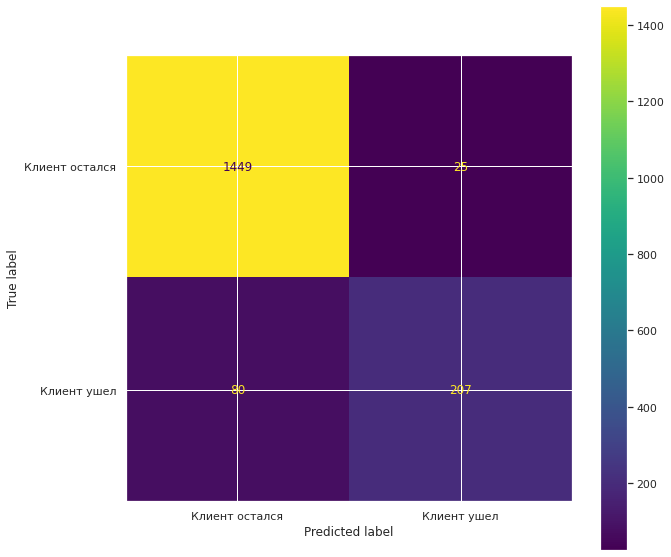

In [67]:
cm = confusion_matrix(target_test, CatBoost_model.predict(features_test)) 
ConfusionMatrixDisplay(cm, display_labels=['Клиент остался', 'Клиент ушел']).plot();

По данной матрице мы имеем: 
- Истинно отрицательные: 1449
- Ложно отрицательные: 80 
- Истинно положительные: 207 
- Ложно положительные: 25

Иными словами, данная матрица показывает, что модель правильно классифицировала 1449 клиентов как продолжающих пользоваться услугами компании и 207 клиентов как уходящих. В свою очередь, модель ошибочно отметила 80 клиентов как остающихся, но они ушли, и 25 клиентов, как уходящих, но они остались. 

### Вывод по моделированию

- Проведен анализ связи признаков и таргета, создан один новый признак и убраны лишние.
- Проведена необходимая кодировка признаков для моделей.
- Обучены две модели CatBoost и случаный лес с результатом по ROC-AUC 0.92 и 0.82 соответственно.
- Лучшей моделью выбран CatBoost, его результат на тестовой выборке - 0.93 по ROC-AUC. Для CatBoost подобран оптимальный порог для accuracy, значение accuracy на тесте - 0.94. 
- Подготовлена и интерпретирована матрица ошибок.

## Отчет

### Этапы работы над проектом

1. EDA
- Преобразование типов данных
- Просмотр распределения и аномалий, дублей, пропусков
- Выделение целевого признака
- Сбор данных в одну таблицу
- Работа с пропусками
2. Моделирование 
- Отбор необходимые для обучения признаки и создание новых
- Деление данных на train и test в соотношении 3 к 1 
- Кодирование признаков
- Обучение 2-3 моделей, выброр лучшей. 
- Оценка модели на тестовой выборке, анализ важности признаков. 
3. Написание отчета

Фактически работа соответствовала плану.

Некоторые сложности возникли с предобработкой данных, а именно с объединением таблиц, поскольку не все клиенты компании пользуются и услугами интернета, и услугами мобильной связи. Это породило некоторое количество пропущенных значений, с которыми нужно было работать, проблема решилась вводом новых категорий.

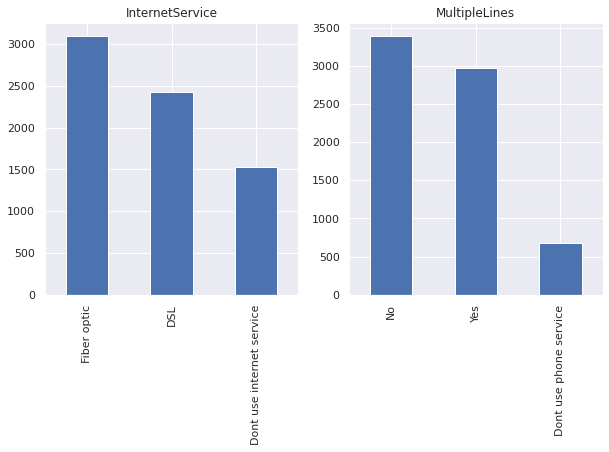

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
full_data.groupby('InternetService')['InternetService'].count().sort_values(ascending=False).plot(kind='bar', ax=axs[0], grid=True, title='InternetService', xlabel='')
full_data.groupby('MultipleLines')['MultipleLines'].count().sort_values(ascending=False).plot(kind='bar', ax=axs[1], grid=True, title='MultipleLines', xlabel='')
plt.show()

Итоговый список признаков для обучения модели составил: 
- PaymentMethod -  способ оплаты;
- MonthlyCharges -  ежемесячные траты на услуги по договору;
- Partner - наличие супруга/супруги;
- Service_duration - длительность обслуживания; 

Из данного списка два признака являются категориальными(PaymentMethod и Partner) и потребовали кодировки, для модели CatBoost был использован внутренний формат Pool, который уже содержит в себе кодировщик, для RandomForest был использован OrdinalEncoder.

Как уже отмечалось выше, на стадии предобработки потребовалось соединить несколько таблиц с разным числом строк, что привело к образованию пропусков, поскольку не все клиенты пользуются всеми услугами компании, эти пропуски были заполнены новыми категориями 'Dont use internet service' и 'Dont use fog service', кроме того были пропуски в столбце TotalCharges, некоторые клиенты на момент выгрузки только заключили договор и не успели ничего потратить, соответственно, эти пропуски были заполнены нулями. Кроме того, были изменены некоторые типы данных столбцов для удобства использования, в частности все столбцы с датами(BeginDate и EndDate) были преобразованы к типу datetime, чтобы с ними можно было работать как с датами, к вещественным числам(float) после удаления пропусков преобразован столбец TotalCharges. Создан новый признак из BeginDate и EndDate - длительность обслуживания.

Обучены следующие модели.

In [69]:
pd.DataFrame({'Модель': ['CatBoost', 'RandomForest'], 
              'Результат AUC-ROC на кросс-валидации': [max(CatBoost_grid['cv_results']['test-AUC-mean']), grid_RF.best_score_]}).sort_values(by=['Результат AUC-ROC на кросс-валидации'], 
                                                           ascending=False)

,Модель,Результат AUC-ROC на кросс-валидации
0,CatBoost,0.913916
1,RandomForest,0.818992


Лучшей моделью ожидаемо оказался CatBoost. Использованы следующие гиперпараметры:
- depth - 4 
- one_hot_max_size - 20,
- l2_leaf_reg - 2,
- iterations - 500
- learning_rate - 0.15 

На данных гиперпараметрах получен результат AUC-ROC порядка 0.91.

На тестовой выборке модель не ухудшила показатели, продемонстрировав значение AUC-ROC и accuracy порядка 0.93 и 0.94 соответственно, иными словами, модель правильно классифицировала 94% тестовой выборки.

Получена следующая матрица ошибок на тестовой выборке.

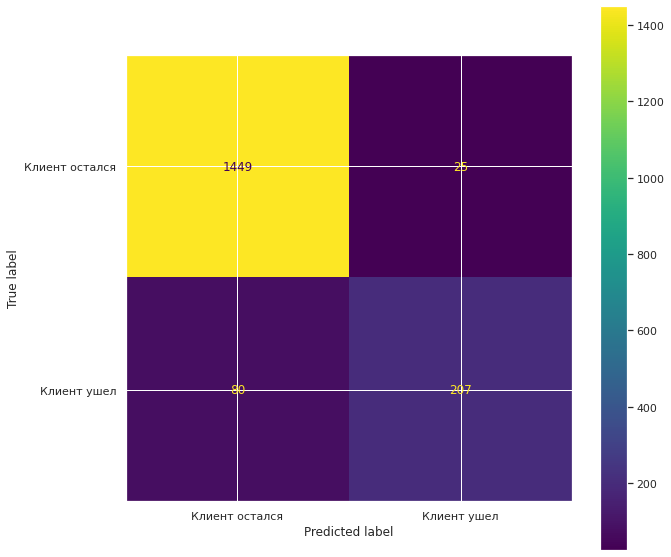

In [70]:
ConfusionMatrixDisplay(cm, display_labels=['Клиент остался', 'Клиент ушел']).plot()

Результат модели по данной матрице : 
- Истинно отрицательные: 1449
- Ложно отрицательные: 80 
- Истинно положительные: 207 
- Ложно положительные: 25

Иными словами, данная матрица показывает, что модель правильно классифицировала 1449 клиентов как продолжающих пользоваться услугами компании и 207 клиента как уходящих. В свою очередь, модель ошибочно отметила 80 клиентов как остающихся, но они ушли, и 25 клиентов, как уходящих, но они остались. 

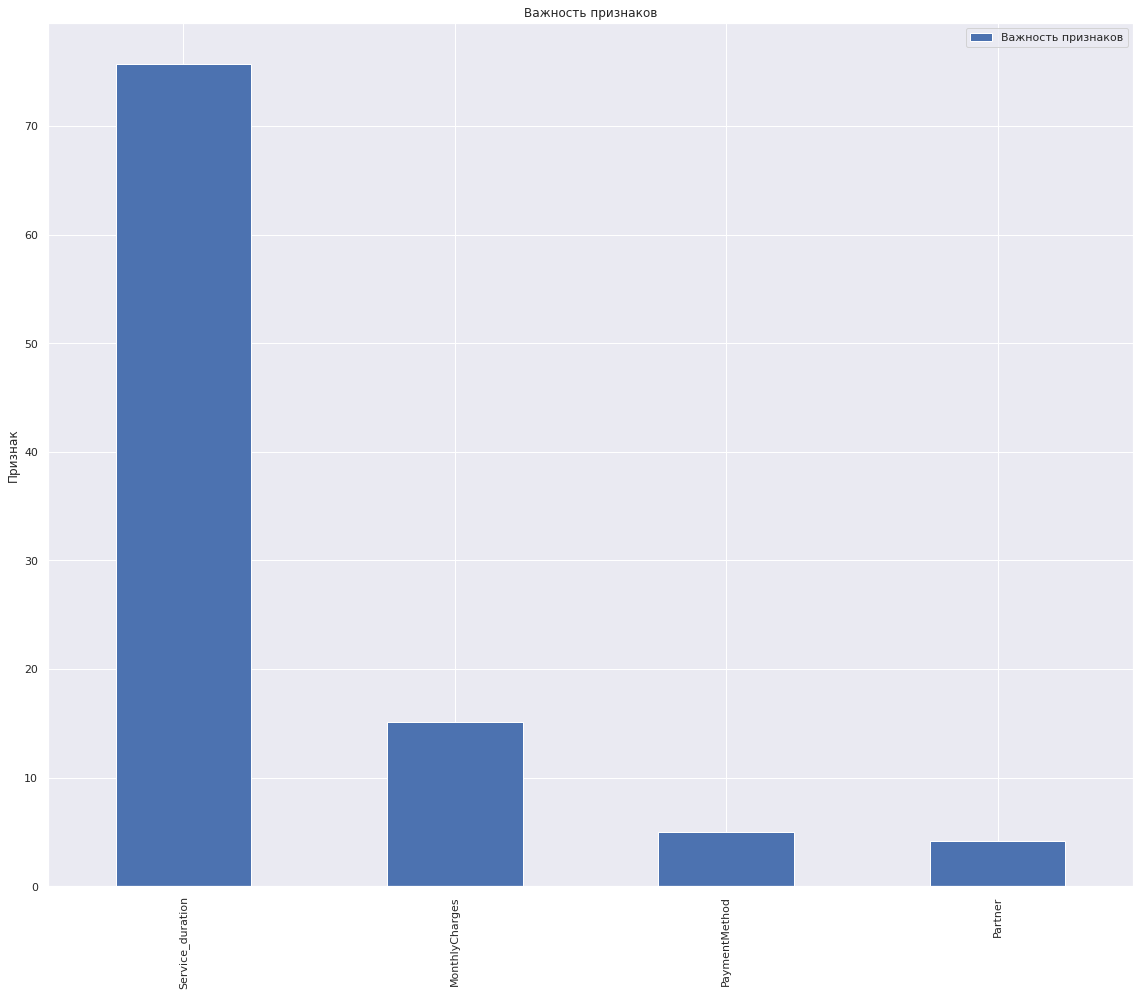

In [71]:
CatBoost_importance = pd.DataFrame({'Важность признаков': CatBoost_model.get_feature_importance(train_pool), 
                                    'Признак': features_train.columns}).sort_values(by=['Важность признаков'], 
                                                                                              ascending=False) 


fig, ax = plt.subplots(figsize=(16,14))
CatBoost_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Признак') 
ax.set_xticklabels(CatBoost_importance['Признак'])
fig.tight_layout() 

Самым важным признаком с большим отрывом оказалась длительность обслуживания, за ней идут месячные платежи, а наименее важным оказались тип оплаты и наличие супруга/супруги.